In [1]:
import stata_setup
import pandas as pd
stata_setup.config("/Applications/STATA","se")


  ___  ____  ____  ____  ____ ®
 /__    /   ____/   /   ____/      18.0
___/   /   /___/   /   /___/       SE—Standard Edition

 Statistics and Data Science       Copyright 1985-2023 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Unlimited-user network, expiring 31 Aug 2024
Serial number: 401809300159
  Licensed to: Bruno Komel
               University of Pittsburgh

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. Maximum number of variables is set to 5,000 but can be increased;
          see help set_maxvar.



. 
. clear

. 
. local units = 30

. local start = 1

. local end       = 60

. 
. local time = `end' - `start' + 1

. local obsv = `units' * `time'

. set obs `obsv'
Number of observations (_N) was 0, now 1,800.

. 
. egen id    = seq(), b(`time')  

. egen t     = seq(), f(`start') t(`end')         

. 
. sort  id t

. xtset id t

Panel variable: id (strongly balanced)
 Time variable: t, 1 to 60
         Delta: 1 unit

. 
. 
. set seed 20211222

. 
. gen Y                   = 0             // outcome variable     

. gen D                   = 0             // intervention variable

. gen cohort      = .     // treatment cohort
(1,800 missing values generated)

. gen effect      = .             // treatment effect size
(1,800 missing values generated)

. gen first_treat = .             // when the treatment happens for each cohort
(1,800 missing values generated)

. gen rel_time    = .     // time - first_treat
(1,800 missing values generated)

. 
. levelsof id, local(lvls) //randoml

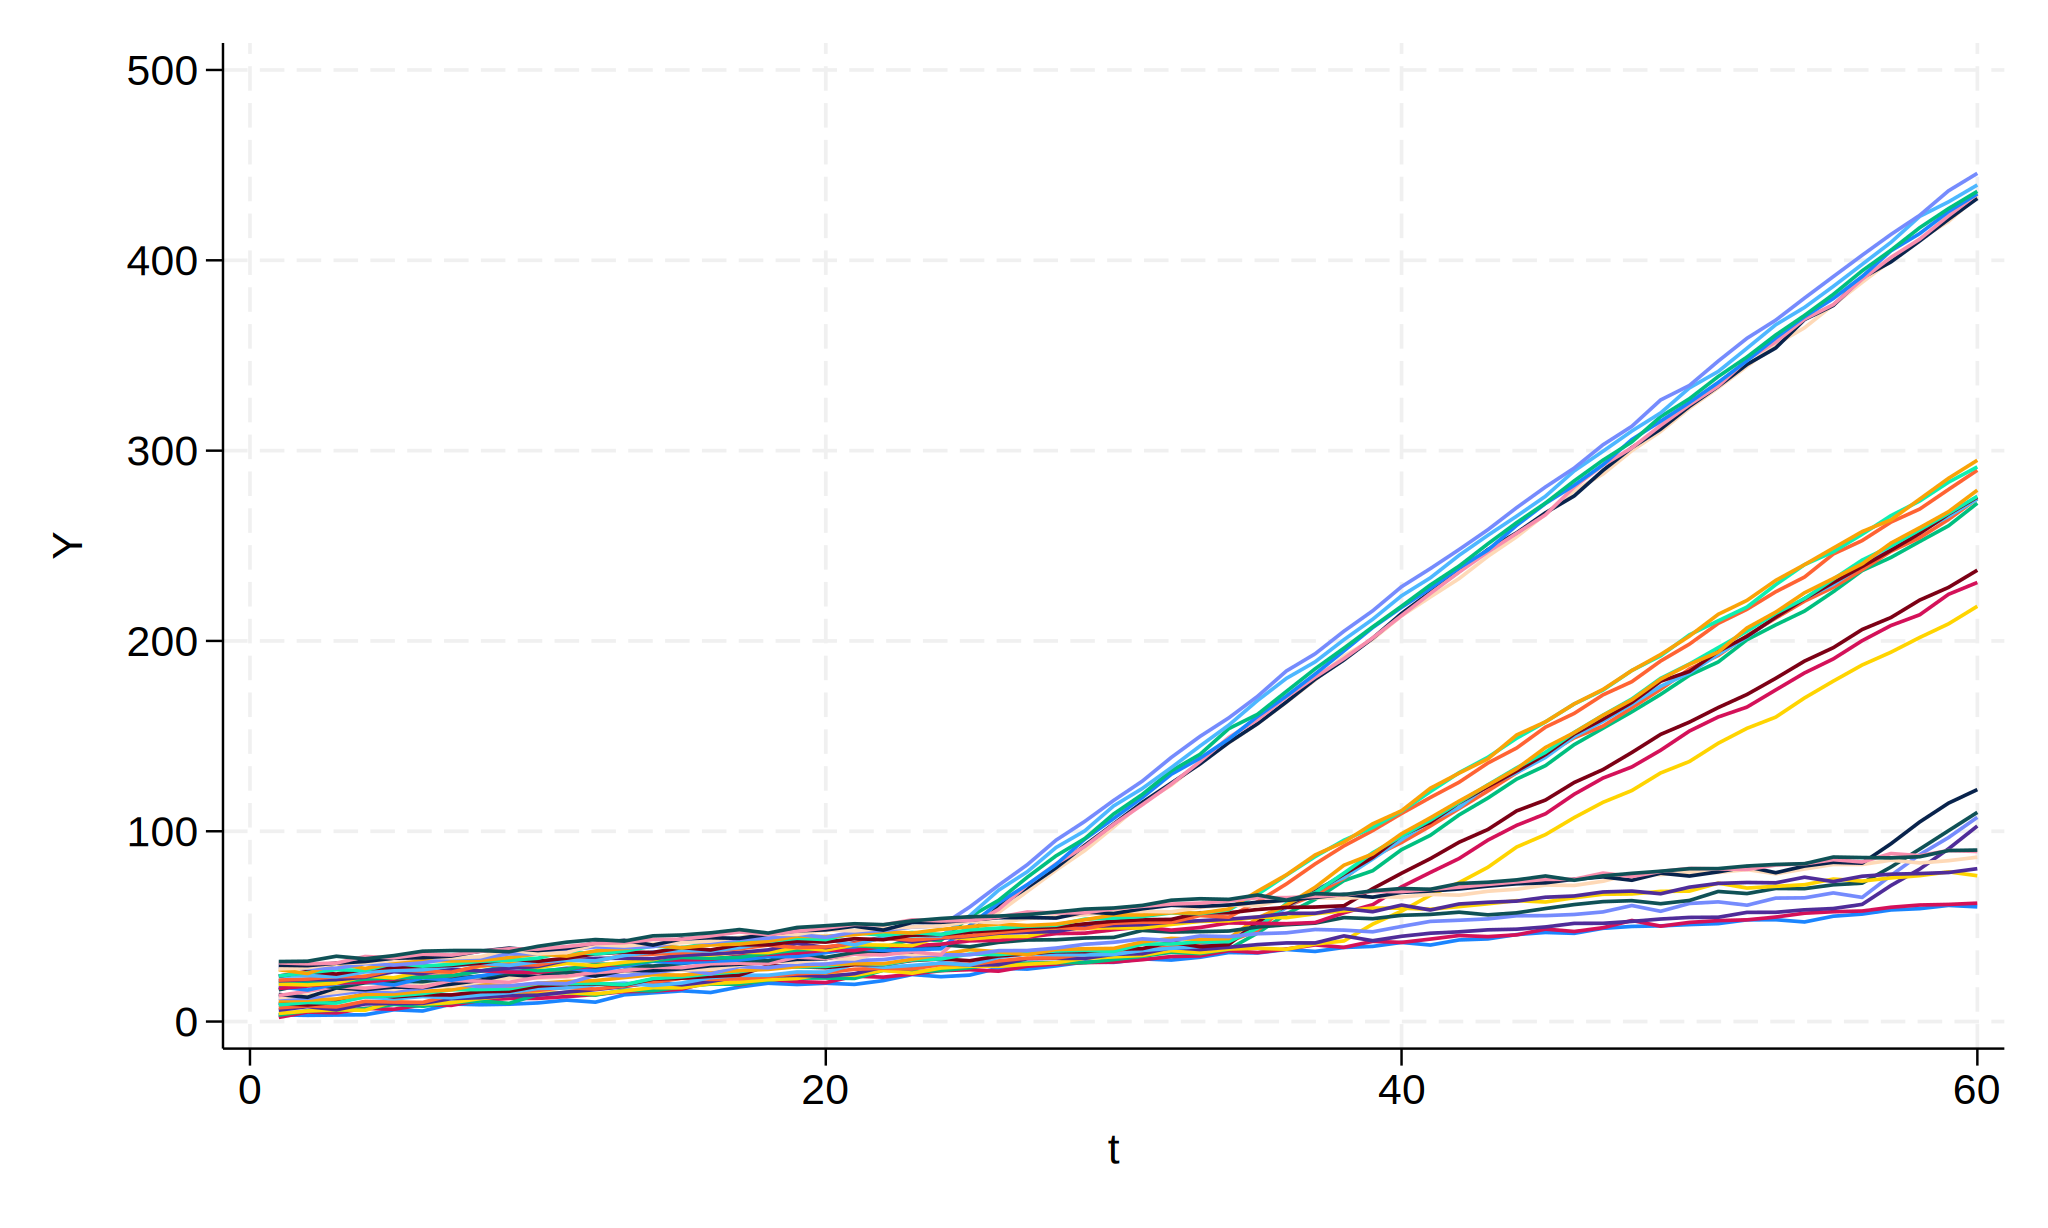

In [2]:
%%stata -doutd df1

clear

local units = 30
local start = 1
local end 	= 60

local time = `end' - `start' + 1
local obsv = `units' * `time'
set obs `obsv'

egen id	   = seq(), b(`time')  
egen t 	   = seq(), f(`start') t(`end') 	

sort  id t
xtset id t


set seed 20211222

gen Y 	   		= 0		// outcome variable	
gen D 	   		= 0		// intervention variable
gen cohort      = .  	// treatment cohort
gen effect      = .		// treatment effect size
gen first_treat = .		// when the treatment happens for each cohort
gen rel_time	= .     // time - first_treat

levelsof id, local(lvls) //randomly assigning observations into cohorts
foreach x of local lvls {
	local chrt = runiformint(0,5)	
	replace cohort = `chrt' if id==`x'
}

levelsof cohort , local(lvls)  
foreach x of local lvls {
	
	local eff = runiformint(2,10)
		replace effect = `eff' if cohort==`x'
			
	local timing = runiformint(`start',`end' + 20)	// 
	replace first_treat = `timing' if cohort==`x'
	replace first_treat = . if first_treat > `end'
		replace D = 1 if cohort==`x' & t>= `timing' 
}

replace rel_time = t - first_treat
replace Y = id + t + cond(D==1, effect * rel_time, 0) + rnormal()

xtline Y, overlay legend(off) // Here we can see the effects of staggered treatments

gen gvar = first_treat
recode gvar (. = 0)



. 
. // Let's simplify this a bit:
. keep if t > 18 & t < 30
(1,470 observations deleted)

. 
. 
. xtline Y, overlay legend(off)

. 


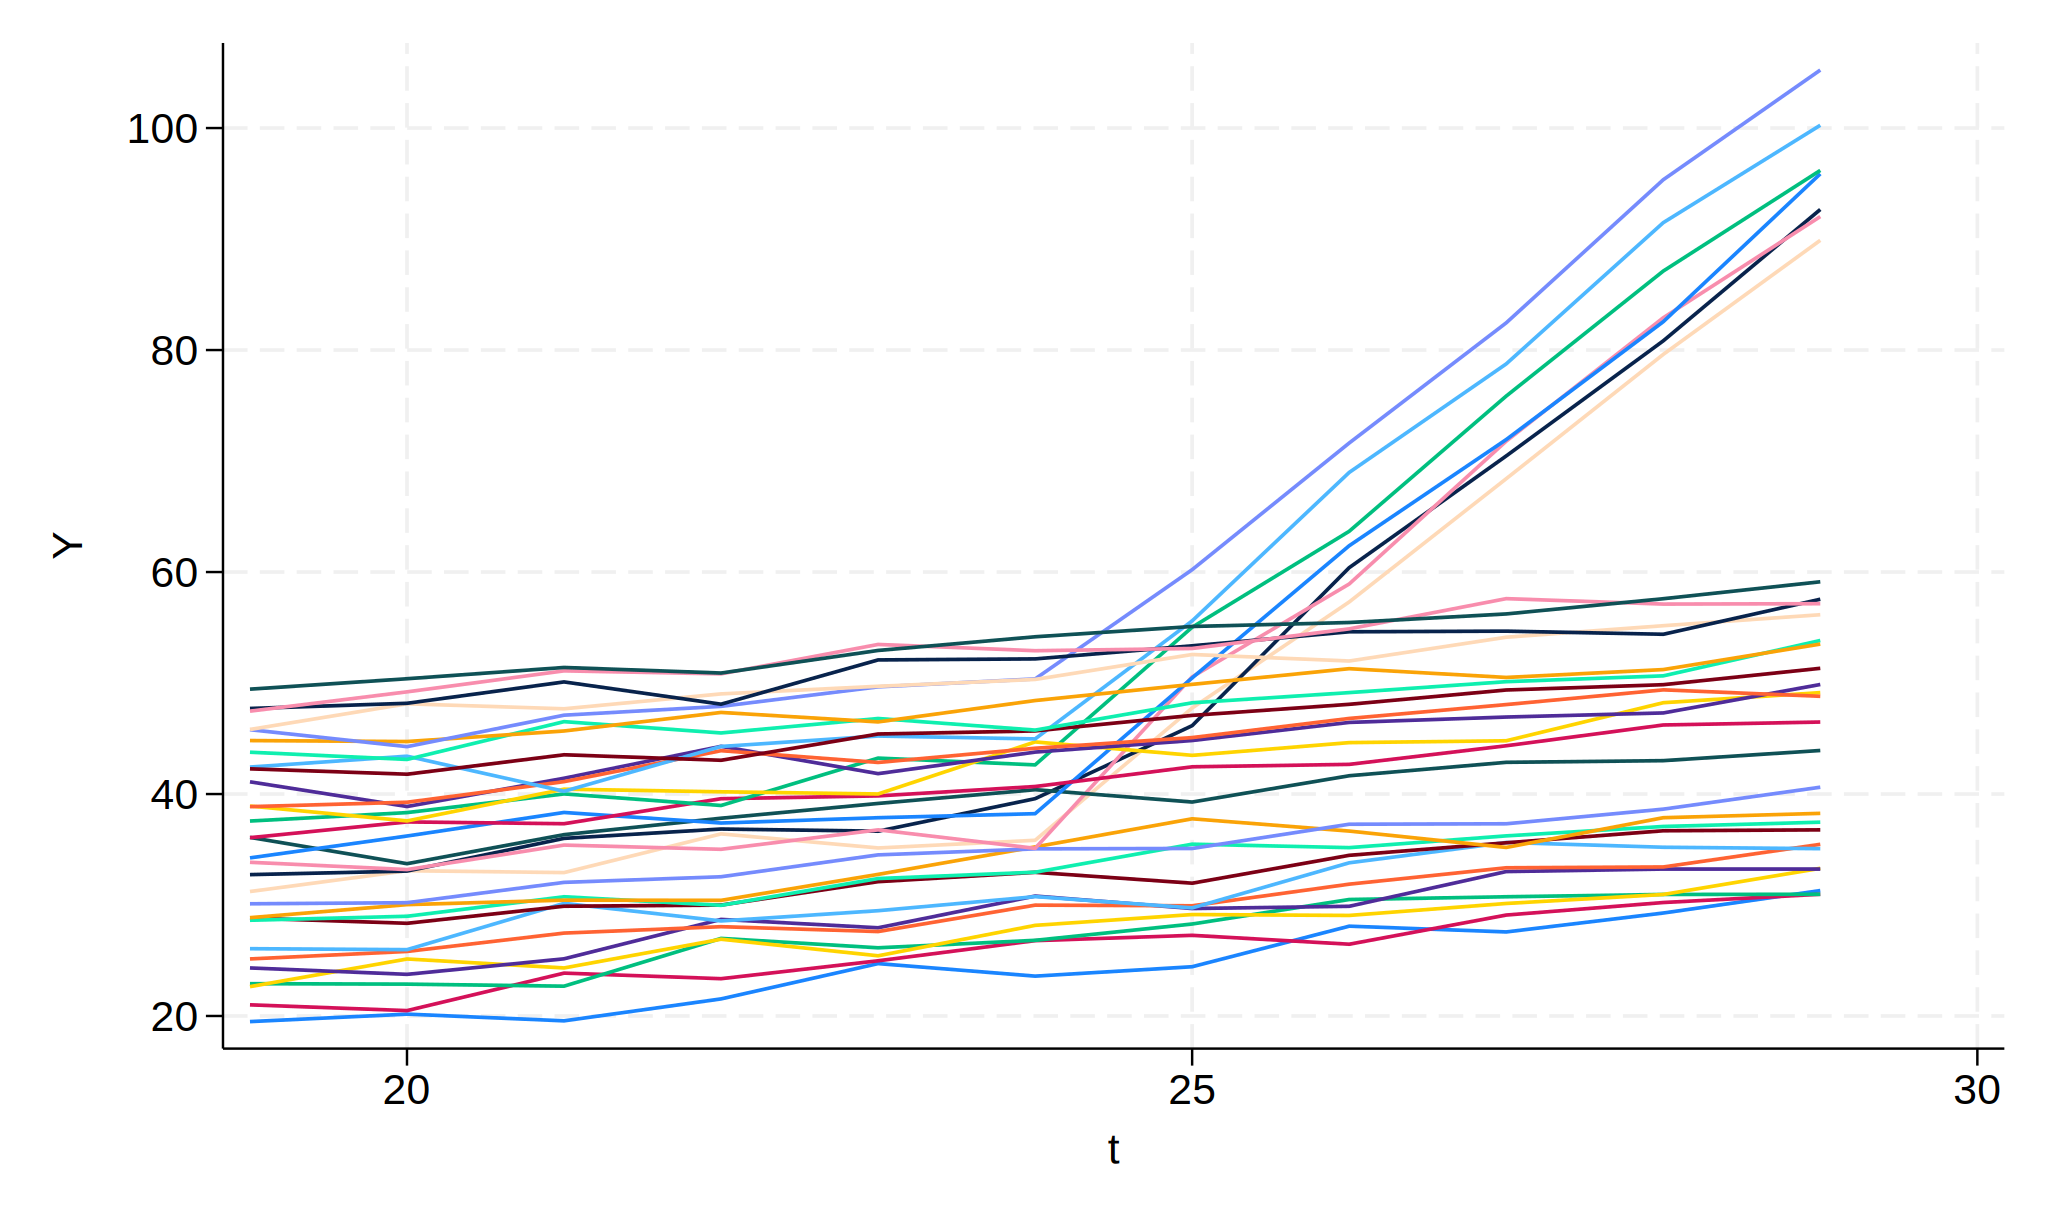

In [3]:
%%stata

// Let's simplify this a bit:
keep if t > 18 & t < 30


xtline Y, overlay legend(off)

In [4]:
display(df1)

,id,t,Y,D,cohort,effect,first_treat,rel_time,gvar
0,1,1,3.506837,0.0,4.0,10.0,8.988466e+307,8.988466e+307,0.0
1,1,2,3.276338,0.0,4.0,10.0,8.988466e+307,8.988466e+307,0.0
2,1,3,3.462954,0.0,4.0,10.0,8.988466e+307,8.988466e+307,0.0
3,1,4,3.578597,0.0,4.0,10.0,8.988466e+307,8.988466e+307,0.0
4,1,5,6.220183,0.0,4.0,10.0,8.988466e+307,8.988466e+307,0.0
...,...,...,...,...,...,...,...,...,...
1795,30,56,86.193092,0.0,4.0,10.0,8.988466e+307,8.988466e+307,0.0
1796,30,57,86.011742,0.0,4.0,10.0,8.988466e+307,8.988466e+307,0.0
1797,30,58,86.631981,0.0,4.0,10.0,8.988466e+307,8.988466e+307,0.0
1798,30,59,89.894966,0.0,4.0,10.0,8.988466e+307,8.988466e+307,0.0


# • TWFE

## How do we estimate the average treatment effect (ATE)?

In [5]:
%%stata

// ssc install reghdfe

reghdfe Y D, abs(cohort t) 



. 
. // ssc install reghdfe
. 
. reghdfe Y D, abs(cohort t) 
(MWFE estimator converged in 2 iterations)

HDFE Linear regression                            Number of obs   =        330
Absorbing 2 HDFE groups                           F(   1,    313) =      96.39
                                                  Prob > F        =     0.0000
                                                  R-squared       =     0.6115
                                                  Adj R-squared   =     0.5916
                                                  Within R-sq.    =     0.2354
                                                  Root MSE        =     9.6253

------------------------------------------------------------------------------
           Y | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
           D |   24.70092   2.515931     9.82   0.000     19.75065     29.6512
       _cons |   39.5122

### This is running a two-way fixed effect regression with cohort and time fixed effects (abs stands for "absorve" that's because the fixed effects model absorves the movement within each category)

## Event Study

In [6]:
%%stata

// First, let's create the indicators for the leads and the lags
// And let's say we're only interested in the 5 periods befre and after treatment

gen rel_time2 = rel_time if abs(rel_time) < 6

tab rel_time2, gen(period_ind) // This will create an indicator variable for each "level" of rel_time2


. 
. // First, let's create the indicators for the leads and the lags
. // And let's say we're only interested in the 5 periods befre and after treat
> ment
. 
. gen rel_time2 = rel_time if abs(rel_time) < 6
(244 missing values generated)

. 
. tab rel_time2, gen(period_ind) // This will create an indicator variable for 
> each "level" of rel_time2

  rel_time2 |      Freq.     Percent        Cum.
------------+-----------------------------------
         -5 |         16       18.60       18.60
         -4 |          7        8.14       26.74
         -3 |          7        8.14       34.88
         -2 |          7        8.14       43.02
         -1 |          7        8.14       51.16
          0 |          7        8.14       59.30
          1 |          7        8.14       67.44
          2 |          7        8.14       75.58
          3 |          7        8.14       83.72
          4 |          7        8.14       91.86
          5 |          7        8.14      100.00
----------

In [7]:
%%stata 

// Let's rename these variables to something more intuitive (leads and lags)
rename period_ind1 lead5 
rename period_ind2 lead4
rename period_ind3 lead3
rename period_ind4 lead2
rename period_ind5 lead1
rename period_ind6 lag0

forval i = 7/11 {
    local lag_suffix = `i' - 6  // Calculates the lag suffix
    rename period_ind`i' lag`lag_suffix'
}


. 
. // Let's rename these variables to something more intuitive (leads and lags)
. rename period_ind1 lead5 

. rename period_ind2 lead4

. rename period_ind3 lead3

. rename period_ind4 lead2

. rename period_ind5 lead1

. rename period_ind6 lag0

. 
. forval i = 7/11 {
  2.     local lag_suffix = `i' - 6  // Calculates the lag suffix
  3.     rename period_ind`i' lag`lag_suffix'
  4. }

. 


In [8]:
%%stata -doutd df2 

rename lag0  ref 
replace ref = 0 // this is making the year prior to treatment our reference year (omitted)


. 
. rename lag0  ref 

. replace ref = 0 // this is making the year prior to treatment our reference y
> ear (omitted)
(251 real changes made)

. 


In [9]:
%%stata

// Let's remove missing values from the control group

foreach var of varlist lead* lag* ref {
    replace `var' = 0 if `var' == .
}


. 
. // Let's remove missing values from the control group
. 
. foreach var of varlist lead* lag* ref {
  2.     replace `var' = 0 if `var' == .
  3. }
(244 real changes made)
(244 real changes made)
(244 real changes made)
(244 real changes made)
(244 real changes made)
(244 real changes made)
(244 real changes made)
(244 real changes made)
(244 real changes made)
(244 real changes made)
(0 real changes made)

. 



. 
. tab cohort

     cohort |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 |         33       10.00       10.00
          1 |         44       13.33       23.33
          2 |         77       23.33       46.67
          3 |         11        3.33       50.00
          4 |         66       20.00       70.00
          5 |         99       30.00      100.00
------------+-----------------------------------
      Total |        330      100.00

. 
. xtline Y if first_treat < 25 | first_treat == . & t > 18 & t < 29, overlay le
> gend(off) // Here we can see the effects of staggered treatments

. 


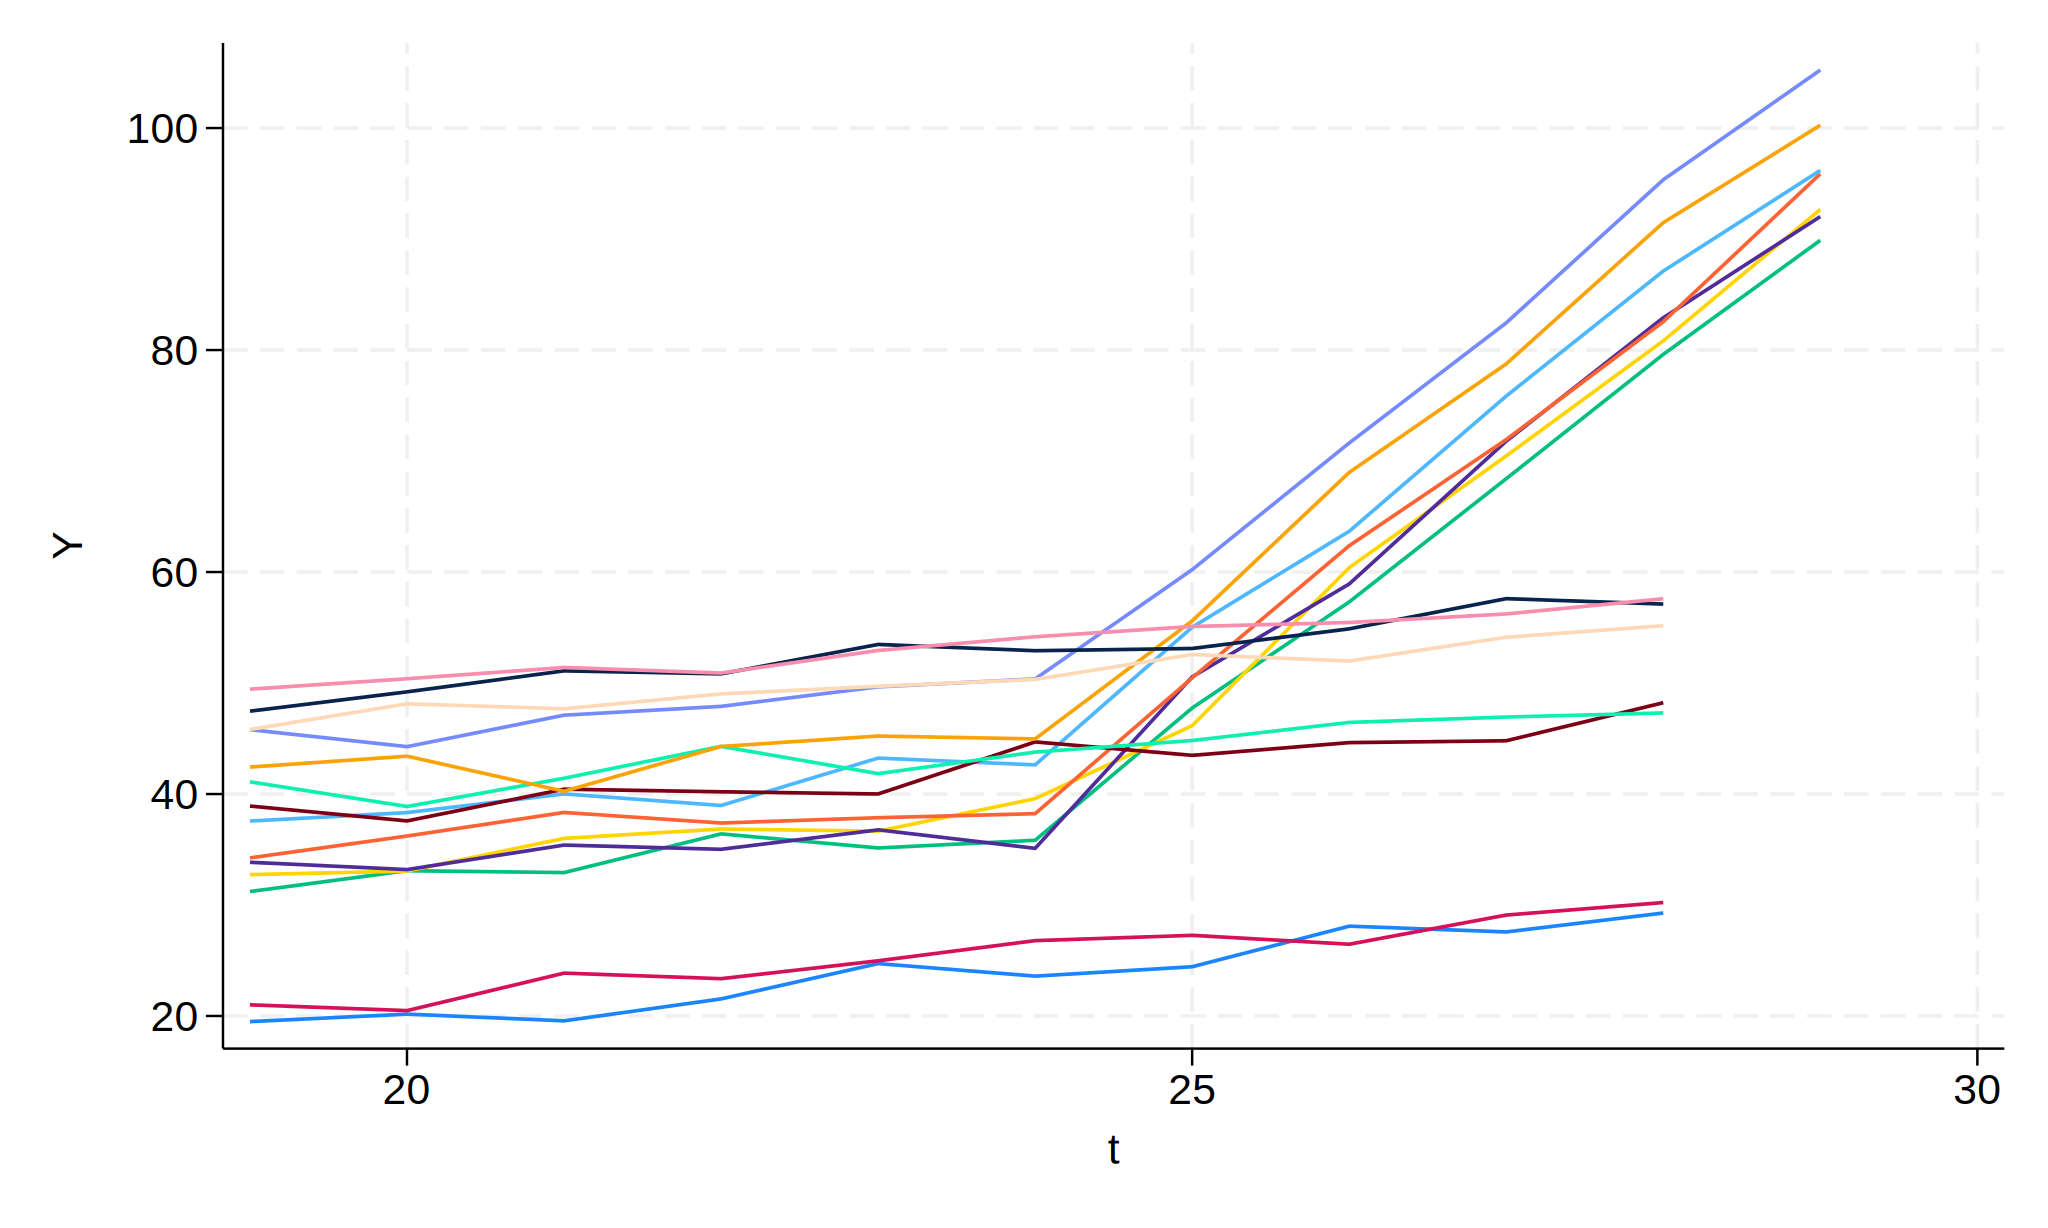

In [10]:
%%stata

tab cohort

xtline Y if first_treat < 25 | first_treat == . & t > 18 & t < 29, overlay legend(off) // Here we can see the effects of staggered treatments


In [11]:
%%stata

 reghdfe Y lead5 lead4 lead3 lead2 lead1 ref lag1 lag2 lag3 lag4 lag5 , absorb(cohort t)



. 
.  reghdfe Y lead5 lead4 lead3 lead2 lead1 ref lag1 lag2 lag3 lag4 lag5 , absor
> b(cohort t)
(MWFE estimator converged in 2 iterations)
note: ref omitted because of collinearity

HDFE Linear regression                            Number of obs   =        330
Absorbing 2 HDFE groups                           F(  10,    304) =      28.67
                                                  Prob > F        =     0.0000
                                                  R-squared       =     0.7385
                                                  Adj R-squared   =     0.7170
                                                  Within R-sq.    =     0.4853
                                                  Root MSE        =     8.0132

------------------------------------------------------------------------------
           Y | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
       lead5 |  -.2792406


. 
. 
. coefplot, keep (lead5 lead4 lead3 lead2 lead1 ref lag1 lag2 lag3 lag4 lag5) /
> //
> omitted vertical xlabel(, angle(vertical)) yline(0) xline(5) recast(connected
> ) xlabel(, angle(0)) ///
> ciopts(recast(rcap) lwidth(*1) lcolor(red))   mcolor(black) lcolor(blue)  ///
>         mlabposition(12) mlabgap(*2) title(Event-Study Plot)  lstyle(grid)  /
> //
>         rename(lead5 = "-5" lead4 = "-4" lead3 = "-3" lead2 = "-2" lead1 = "-
> 2" lead1 = "-1" ref = "0" lag1 = "1" lag2 = "2" lag3 = "3" lag4 = "4" lag5 = 
> "5" )  ///
>         addplot(scatteri -21 5 -21 6 61 6 61 5, recast(area) lwidth(none) col
> or(gray%10) ) 

. 


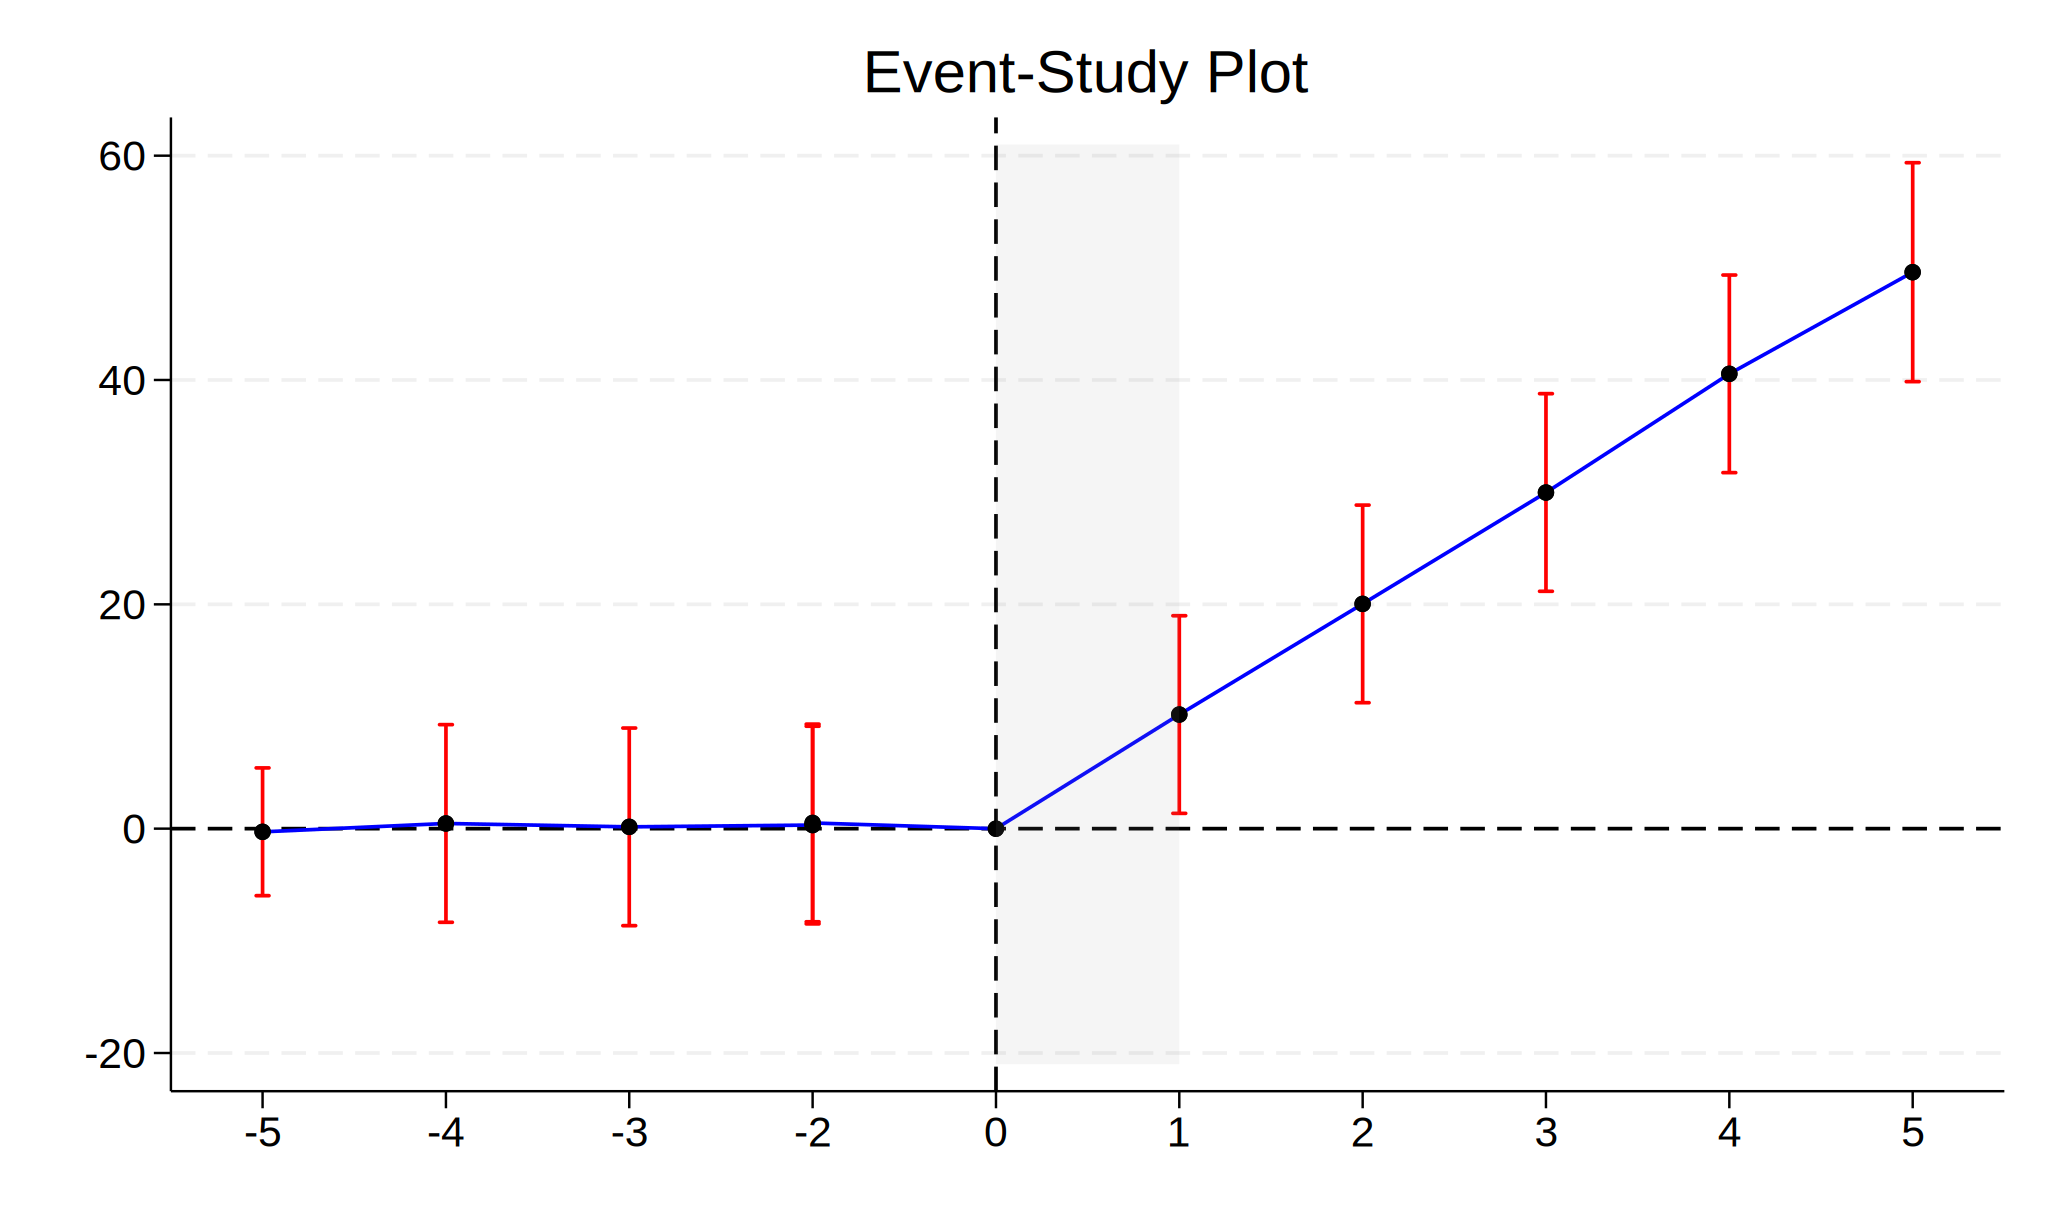

In [12]:
%%stata


coefplot, keep (lead5 lead4 lead3 lead2 lead1 ref lag1 lag2 lag3 lag4 lag5) ///
omitted vertical xlabel(, angle(vertical)) yline(0) xline(5) recast(connected) xlabel(, angle(0)) ///
ciopts(recast(rcap) lwidth(*1) lcolor(red))   mcolor(black) lcolor(blue)  ///
	mlabposition(12) mlabgap(*2) title(Event-Study Plot)  lstyle(grid)  ///
	rename(lead5 = "-5" lead4 = "-4" lead3 = "-3" lead2 = "-2" lead1 = "-2" lead1 = "-1" ref = "0" lag1 = "1" lag2 = "2" lag3 = "3" lag4 = "4" lag5 = "5" )  ///
	addplot(scatteri -21 5 -21 6 61 6 61 5, recast(area) lwidth(none) color(gray%10) ) 

## But what do each of those commands do?

### Ask GPT 

# Exercise

Based on Cheng and Hoesktra (2013) [Thanks, @Causal Inference The Mixtape]

Studies the effect of castle-doctrine statutes passed in 21 states between 2000 and 2010. These statutes extended one's right to use lethal self-defense such that it was no longer limited to one's home, but also to other public places.

So this paper studies the effect of these doctrines on the (log) number of homicides.

In [13]:
%%stata -doutd df3

use https://github.com/scunning1975/mixtape/raw/master/castle.dta, clear

* define global macros
global crime1 jhcitizen_c jhpolice_c murder homicide  robbery assault burglary larceny motor robbery_gun_r 
global demo blackm_15_24 whitem_15_24 blackm_25_44 whitem_25_44 //demographics
global lintrend trend_1-trend_51 //state linear trend
global region r20001-r20104  //region-quarter fixed effects
global exocrime l_larceny l_motor // exogenous crime rates
global spending l_exp_subsidy l_exp_pubwelfare
global xvar l_police unemployrt poverty l_income l_prisoner l_lagprisoner $demo $spending



. 
. use https://github.com/scunning1975/mixtape/raw/master/castle.dta, clear

. 
. * define global macros
. global crime1 jhcitizen_c jhpolice_c murder homicide  robbery assault burglar
> y larceny motor robbery_gun_r 

. global demo blackm_15_24 whitem_15_24 blackm_25_44 whitem_25_44 //demographic
> s

. global lintrend trend_1-trend_51 //state linear trend

. global region r20001-r20104  //region-quarter fixed effects

. global exocrime l_larceny l_motor // exogenous crime rates

. global spending l_exp_subsidy l_exp_pubwelfare

. global xvar l_police unemployrt poverty l_income l_prisoner l_lagprisoner $de
> mo $spending

. 


In [14]:
display(df3)

,state,year,sid,cdl,pre2_cdl,caselaw,anywhere,assumption,civil,homicide_c,...,_Iyear_2002,_Iyear_2003,_Iyear_2004,_Iyear_2005,_Iyear_2006,_Iyear_2007,_Iyear_2008,_Iyear_2009,_Iyear_2010,popwt
0,Alabama,2000,1,0.0,0.0,0.0,0,0,0,329,...,0,0,0,0,0,0,0,0,0,4.499293e+06
1,Alabama,2001,1,0.0,0.0,0.0,0,0,0,379,...,0,0,0,0,0,0,0,0,0,4.499293e+06
2,Alabama,2002,1,0.0,0.0,0.0,0,0,0,303,...,1,0,0,0,0,0,0,0,0,4.499293e+06
3,Alabama,2003,1,0.0,0.0,0.0,0,0,0,299,...,0,1,0,0,0,0,0,0,0,4.499293e+06
4,Alabama,2004,1,0.0,1.0,0.0,0,0,0,254,...,0,0,1,0,0,0,0,0,0,4.499293e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,Wyoming,2006,51,0.0,0.0,0.0,0,0,0,13,...,0,0,0,0,1,0,0,0,0,5.047802e+05
546,Wyoming,2007,51,0.0,0.0,0.0,0,0,0,21,...,0,0,0,0,0,1,0,0,0,5.047802e+05
547,Wyoming,2008,51,0.0,0.0,0.0,0,1,1,12,...,0,0,0,0,0,0,1,0,0,5.047802e+05
548,Wyoming,2009,51,0.0,0.0,0.0,0,1,1,11,...,0,0,0,0,0,0,0,1,0,5.047802e+05


### 0. Figure out what the treatment variable is

post

### 1. Estimate the ATE of the treatment variable on log homicides.
### Make sure to use year and state fixed effects. (Hint: you should also use population weights, popwt)
### Also, you should control for region, linear trends, and other covariates that were stored as globals

In [15]:
%%stata 

xtset

label variable post "Year of treatment"
xi: xtreg l_homicide post i.year $region $xvar $lintrend  [aweight=popwt], fe vce(cluster sid)


. 
. xtset

Panel variable: sid (strongly balanced)
 Time variable: year, 2000 to 2010
         Delta: 1 unit

. 
. label variable post "Year of treatment"

. xi: xtreg l_homicide post i.year $region $xvar $lintrend  [aweight=popwt], fe
>  vce(cluster sid)
i.year            _Iyear_2000-2010    (naturally coded; _Iyear_2000 omitted)
note: r20004 omitted because of collinearity.
note: r20014 omitted because of collinearity.
note: r20024 omitted because of collinearity.
note: r20034 omitted because of collinearity.
note: r20044 omitted because of collinearity.
note: r20054 omitted because of collinearity.
note: r20064 omitted because of collinearity.
note: r20074 omitted because of collinearity.
note: r20084 omitted because of collinearity.
note: r20094 omitted because of collinearity.
note: r20101 omitted because of collinearity.
note: r20102 omitted because of collinearity.
note: r20103 omitted because of collinearity.
note: r20104 omitted because of collinearity.
note: trend_9 omitted

In [16]:
%%stata

// My preferred command
reghdfe l_homicide  post $region $xvar $lintrend  [aw = popwt], vce(cluster sid) absorb(year sid)


. 
. // My preferred command
. reghdfe l_homicide  post $region $xvar $lintrend  [aw = popwt], vce(cluster s
> id) absorb(year sid)
(MWFE estimator converged in 2 iterations)
> clusters
note: r20004 omitted because of collinearity
note: r20014 omitted because of collinearity
note: r20024 omitted because of collinearity
note: r20034 omitted because of collinearity
note: r20044 omitted because of collinearity
note: r20054 omitted because of collinearity
note: r20064 omitted because of collinearity
note: r20074 omitted because of collinearity
note: r20084 omitted because of collinearity
note: r20094 omitted because of collinearity
note: r20101 omitted because of collinearity
note: r20102 omitted because of collinearity
note: r20103 omitted because of collinearity
note: r20104 omitted because of collinearity
note: trend_9 omitted because of collinearity
note: trend_46 omitted because of collinearity
note: trend_49 omitted because of collinearity
note: trend_50 omitted because of collinear

-----------------------------------------------------+
 Absorbed FE | Categories  - Redundant  = Num. Coefs |
-------------+---------------------------------------|
        year |        11           0          11     |
         sid |        50          50           0    *|
-----------------------------------------------------+
* = FE nested within cluster; treated as redundant for DoF computation

. 


### 2. Now create an event-study plot for this setting.

In [17]:
%%stata

gen ref = 0

* Event study regression with the year of treatment (lag0) as the omitted category.
reghdfe l_homicide lead9 lead8 lead7 lead6 lead5 lead4 lead3 lead2 lead1 ref lag1-lag5  $region [aweight=popwt], absorb(year sid) vce(cluster sid)


. 
. gen ref = 0

. 
. * Event study regression with the year of treatment (lag0) as the omitted cat
> egory.
. reghdfe l_homicide lead9 lead8 lead7 lead6 lead5 lead4 lead3 lead2 lead1 ref 
> lag1-lag5  $region [aweight=popwt], absorb(year sid) vce(cluster sid)
(MWFE estimator converged in 2 iterations)
note: ref omitted because of collinearity
note: r20004 omitted because of collinearity
note: r20014 omitted because of collinearity
note: r20024 omitted because of collinearity
note: r20034 omitted because of collinearity
note: r20044 omitted because of collinearity
note: r20054 omitted because of collinearity
note: r20064 omitted because of collinearity
note: r20074 omitted because of collinearity
note: r20084 omitted because of collinearity
note: r20094 omitted because of collinearity
note: r20101 omitted because of collinearity
note: r20102 omitted because of collinearity
note: r20103 omitted because of collinearity
note: r20104 omitted because of collinearity

HDFE Linear regressio


. set scheme tab1

. 
. coefplot, keep(lead9 lead8 lead7 lead6 lead5 lead4 lead3 lead2 lead1 ref lag1
>  lag2 lag3 lag4 lag5 ) ///
>         xlabel(, angle(vertical))  yline(-.5(0.25)0.5) xline(10) vertical omi
> tted recast(connected) xlabel(, angle(0)) ///
>         ciopts(recast(rcap) lwidth(*1) lcolor(gs2) ) format(%9.0f)   mcolor(g
> s2) lcolor(gs2) ///
>         mlabposition(12) mlabgap(*2) title(Event-Study Plot)  lstyle(grid) //
> /
>         rename(lead9 = "-9" lead8 = "-8" lead7 = "-7" lead6 = "-6"   lead5 = 
> "-5" lead4 = "-4" lead3 = "-3" lead2 = "-2"  lead1 = "-1" ref = "0" lag1 = "1
> " lag2 = "2" lag3 = "3" lag4 = "4" lag5 = "5" )  ///
>         addplot(scatteri -.5 10 -.5 11 .5 11 .5 10, recast(area) lwidth(none)
>  color(grey%10) ) 
(note:  named style grey not found in class color, default attributes used)
(note:  named style grey not found in class color, default attributes used)
(note:  named style grey not found in class color, default attributes used)
(note:  na

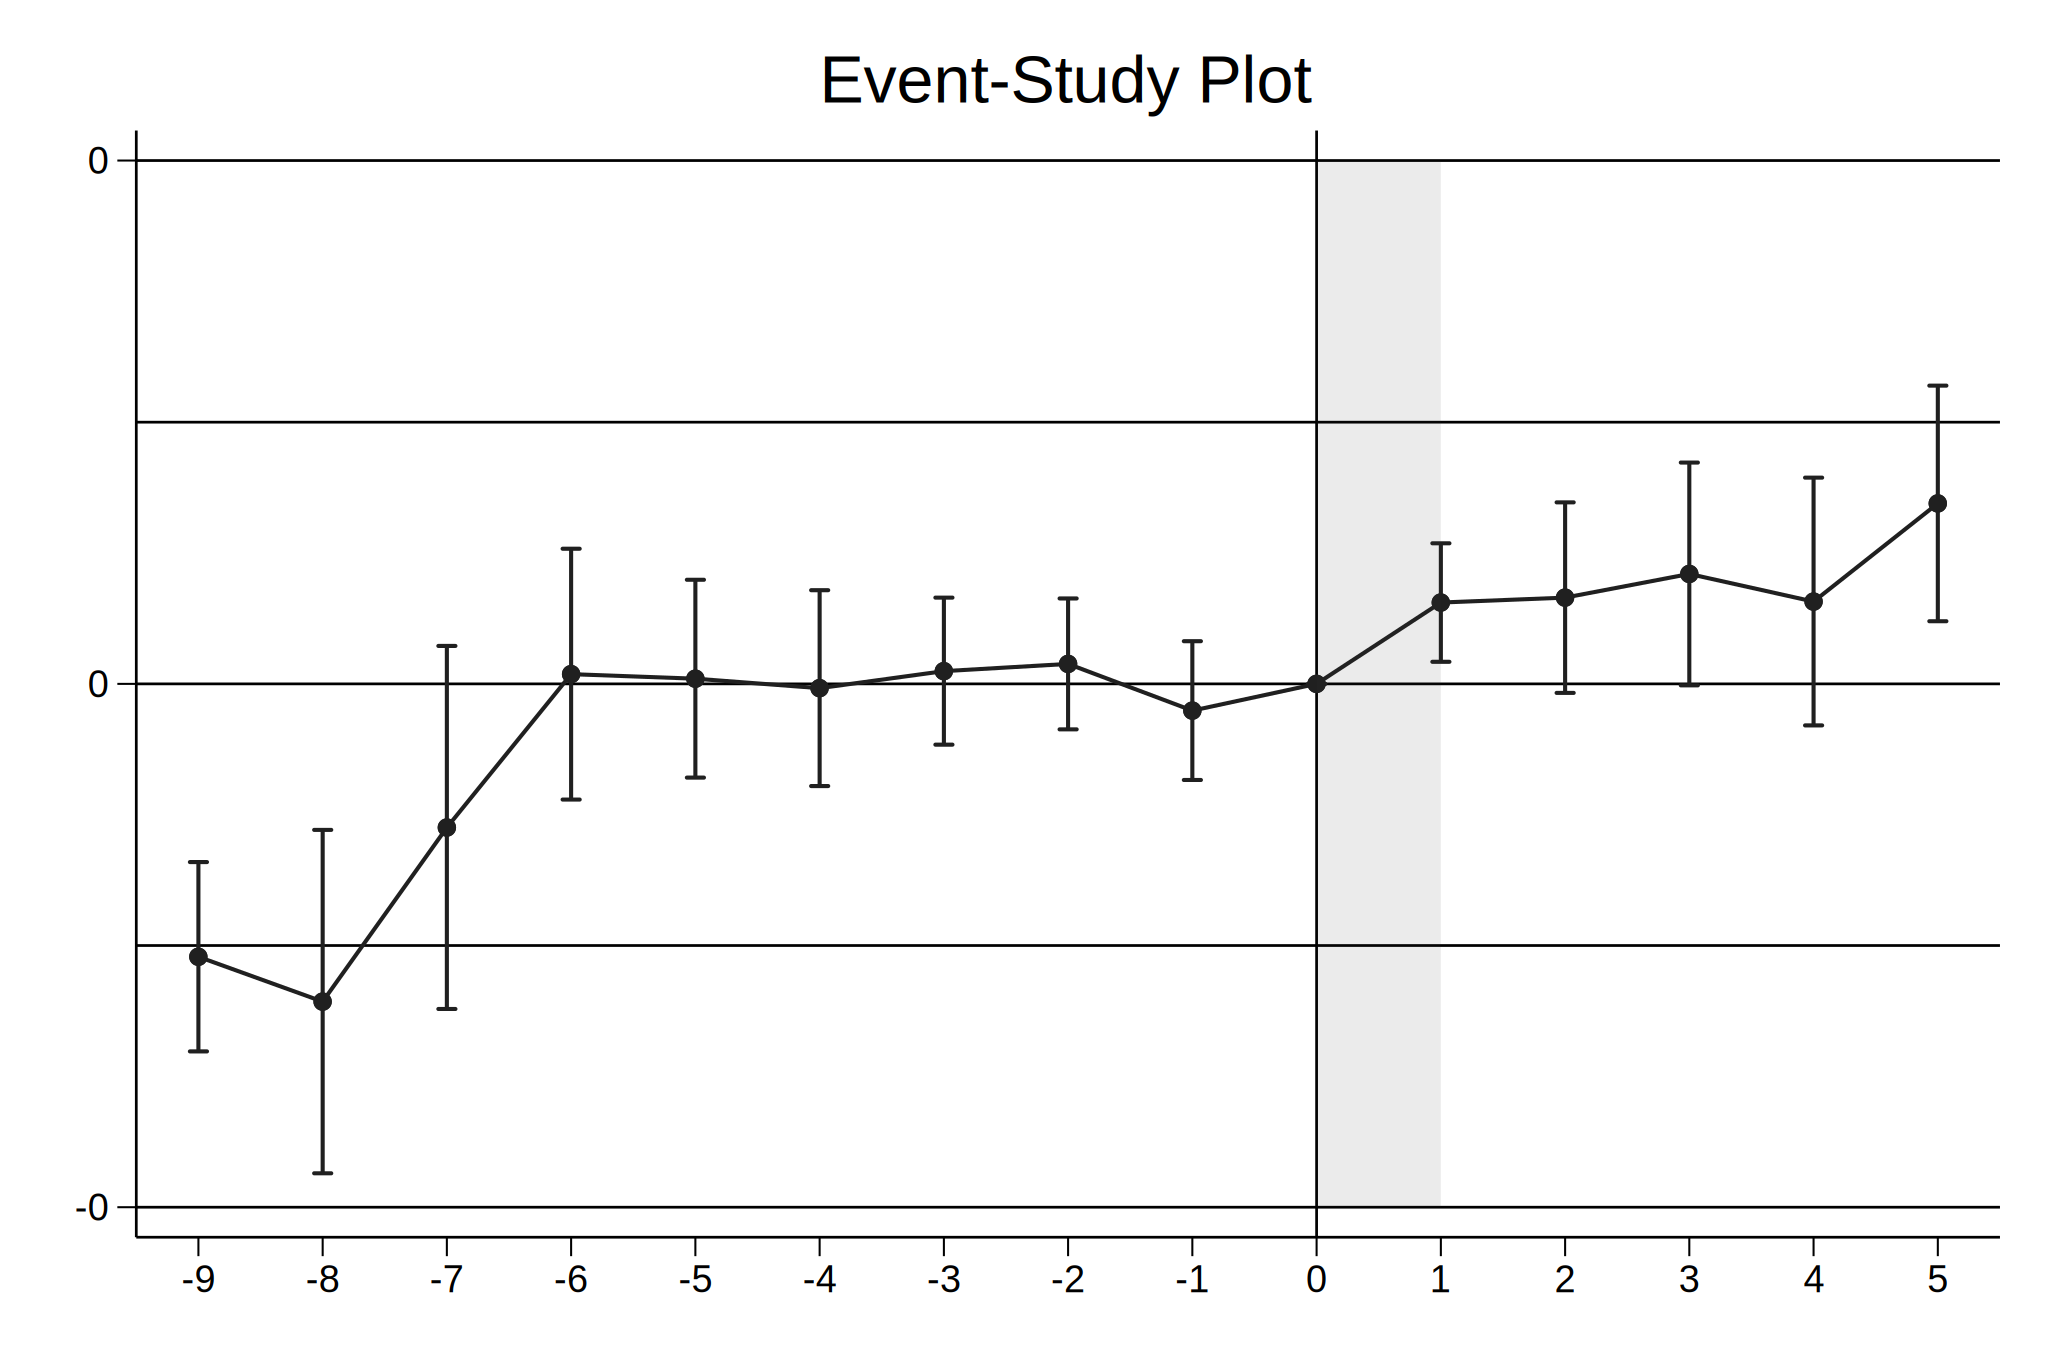

In [18]:
%%stata
set scheme tab1

coefplot, keep(lead9 lead8 lead7 lead6 lead5 lead4 lead3 lead2 lead1 ref lag1 lag2 lag3 lag4 lag5 ) ///
	xlabel(, angle(vertical))  yline(-.5(0.25)0.5) xline(10) vertical omitted recast(connected) xlabel(, angle(0)) ///
	ciopts(recast(rcap) lwidth(*1) lcolor(gs2) ) format(%9.0f)   mcolor(gs2) lcolor(gs2) ///
	mlabposition(12) mlabgap(*2) title(Event-Study Plot)  lstyle(grid) ///
	rename(lead9 = "-9" lead8 = "-8" lead7 = "-7" lead6 = "-6"   lead5 = "-5" lead4 = "-4" lead3 = "-3" lead2 = "-2"  lead1 = "-1" ref = "0" lag1 = "1" lag2 = "2" lag3 = "3" lag4 = "4" lag5 = "5" )  ///
	addplot(scatteri -.5 10 -.5 11 .5 11 .5 10, recast(area) lwidth(none) color(grey%10) ) 
